# CZ1115 - Team WIN Data Science Project 

### Model Name: Natural Language Proccessing - Multi-Label Classification [NLP - MLC]

---



> **Our Goal: Explore various models to predict the genres of movies in TMDB based on their overview.**

*The first model we will be testing on will be the Natural Language Proccessing - Multi-Label Classifier.*

# 0. Import Required Libraries

In [61]:
import requests,json,csv,os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import time
from nltk.stem import WordNetLemmatizer
import sys
from sklearn.metrics import accuracy_score
sb.set()

**Our API Key: '9c9de4f24b3a171f5962aaa463a6b351'**



# 1. Data Preparation

1.1 We made use the API (the discover function) to obtain values for our datset. Each call only give us ~20 entries as the data is split into different 'pages'. Hence, we had to iterate through the pages to obtain more data for our dataset.

The table below shows all the genres present in The Movie Database API (TMDB):

| **genres_id** | 28 | 12 | 16 | 35 | 80 | 99 | 18 | 10751 | 14 | 36 | 27 | 10402 | 9648 | 10749 | 878 | 10770 | 53 | 10752 | 37 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **genres_name** | Action | Adventure | Animation | Comedy | Crime | Documentary | Drama | Family | Fantasy | History | Horror | Music | Mystery | Romance | Science Fiction | TV Movie | Thriller | War | Western |
<br><br>

> We originally tested our model with all 19 genres, however, prediction accuracy was very low, due to gap in the amount data per genre, causing an imbalanced learning problem.

Therefore we decided on using 5 out of the 19 genres to test and train our model on, and the genres are:

| **genres_id** | 35 | 99 | 18 | 10749 | 53 |
| --- | --- | --- | --- | --- | --- |
| **genres_name** | Comedy | Documentary | Drama | Romance | Thriller |

> Reason for genre choices:
> * Distinct descriptions (e.g. unlike Horror, Mystery against Thriller)
> * Most balanced combination of 5 genres
> * Substantial amount of data for each genre

We made use of the built-in API function, without_genres, by extending our API URL caller with genres that are not our targeted genres, using their IDs.

In [62]:
discover_api_url = 'https://api.themoviedb.org/3/discover/movie?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-Us&without_genres=12,16,28,80,10751,14,36,27,10402,9648,878,10770,10752,37'


discover_api = requests.get(discover_api_url).json()
movies = discover_api["results"]
for page in range(2, discover_api["total_pages"]+1): # if want all pages, change end range to "discover_api["total_pages"]+1"
    try:
      discover_api = requests.get(discover_api_url + f"&page={page}").json()
      movies.extend(discover_api["results"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

1.2 Now we populate different lists according to what data we require.
> Required data:
*   Titles
*   Overview
*   Genre ID

Notice that for genres we went on to obtain their ID instead of the name. This is because the genres are in dictionary form, so the IDs act as the keys while the genres as the values.

In [63]:
# get all the titles and put into a list
titles = []
for i , film in enumerate(movies):
  titles.append(film['original_title'])

# get all the overviews and put into a list
overviews = []
for i , film in enumerate(movies):
  overviews.append(film['overview'])

# get all the genre IDs and put into a list
genres = []
for i , film in enumerate(movies):
  genres.append(film['genre_ids'])

1.3 We now repeat the same process as in 1.1 with the genre function of the API, to obtain the names of the genre and link them to their respective IDs.

In [64]:
#get genre movie list from TMDb (to convert ID to name of genre)
discover_genre_api_url = 'https://api.themoviedb.org/3/genre/movie/list?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-US'
discover_genre_api = requests.get(discover_genre_api_url).json()
genre_list = discover_genre_api["genres"]
time.sleep(0.01)
for page in range(2, discover_api["total_pages"]+1): 
    try:
      discover_genre_api = requests.get(discover_genre_api_url + f"&page={page}").json()
      genre_list.extend(discover_genre_api["genres"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

#make it a dictionary
dict = {}
for i, film_genre in enumerate(genre_list):
    dict[film_genre['id']] = film_genre['name']

#convert genre IDs to names
for i in range(len(genres)):
    for j in range(len(genres[i])):
        genres[i][j] = dict[genres[i][j]]

1.4 Now that we have the data we want, we put it into a dataframe in preparation for data cleaning.

In [65]:
dat = {'titles': titles, 'overviews': overviews, 'genres': genres}
df = pd.DataFrame(data=dat)
df.head()

,titles,overviews,genres
0,Bad Trip,Two pals embark on a road trip full of funny p...,[Comedy]
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"[Comedy, Romance]"
2,After We Collided,Tessa finds herself struggling with her compli...,"[Romance, Drama]"
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,[Comedy]
4,彼女,Rei helps the woman she's been in love with fo...,"[Drama, Romance, Thriller]"


# 2. Data Cleaning* 

##### * more cleaning done in part 4

2.1 As we explored the data we obtained from the TMDB, we encountered `empty lists in the genre column` and also `empty strings in the overview column`.

Hence, we iterated through the whole dataframe, dropping any row that contained the empty list/strings as it would not help us in creating an accurate genre predictor.

In [66]:
# check for empty list 
# empty = (df.loc[df['genres'].str.len()<1])
# print(empty)

# To view all rows: 
# pd.set_option('display.max_rows', None)

# drop empty list from genre column
for i, row in enumerate(df['genres']):
  if row == []:
    df = df.drop([i])

# drop empty strings from overviews column
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset=["overviews"], inplace=True)
df

,titles,overviews,genres
0,Bad Trip,Two pals embark on a road trip full of funny p...,[Comedy]
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"[Comedy, Romance]"
2,After We Collided,Tessa finds herself struggling with her compli...,"[Romance, Drama]"
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,[Comedy]
4,彼女,Rei helps the woman she's been in love with fo...,"[Drama, Romance, Thriller]"
...,...,...,...
9995,おくりびと,"Daigo, a cellist, is laid off from his orchest...",[Drama]
9996,The Science of Interstellar,Matthew McConaughey narrates a fascinating loo...,[Documentary]
9997,The Gospel According to Philip K. Dick,"Writers, publishers, fans, and friends share t...",[Documentary]
9998,Alcatraz: Search for the Truth,More than 50 years after three men broke out o...,[Documentary]


# 3. Data Visualization

3.1 To be able to better visualize our data, we used the explode function to transform each element of the genre list to a row, replicating index values. We further check for empty rows and make to drop them to get more accurate data.

In [67]:
df2 = df.explode('genres')
df2.dropna(subset = ["genres"], inplace=True)
df2

,titles,overviews,genres
0,Bad Trip,Two pals embark on a road trip full of funny p...,Comedy
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,Comedy
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,Romance
2,After We Collided,Tessa finds herself struggling with her compli...,Romance
2,After We Collided,Tessa finds herself struggling with her compli...,Drama
...,...,...,...
9995,おくりびと,"Daigo, a cellist, is laid off from his orchest...",Drama
9996,The Science of Interstellar,Matthew McConaughey narrates a fascinating loo...,Documentary
9997,The Gospel According to Philip K. Dick,"Writers, publishers, fans, and friends share t...",Documentary
9998,Alcatraz: Search for the Truth,More than 50 years after three men broke out o...,Documentary


3.2 We now create a dictionary to store the genre names as the key and the number of occurence of a particular genre as the value.

In [68]:
categories = {}
for item in df2['genres']:
        if item in categories:
            categories[item] += 1
        else:
            categories[item] = 0
    
print("Number of categories: {}".format(len(categories)))
print(categories)

Number of categories: 5
{'Comedy': 3919, 'Romance': 2350, 'Drama': 4749, 'Thriller': 917, 'Documentary': 2109}


3.3 To see how many occurences per genre, we plot a bar graph for comparison. 

<BarContainer object of 5 artists>

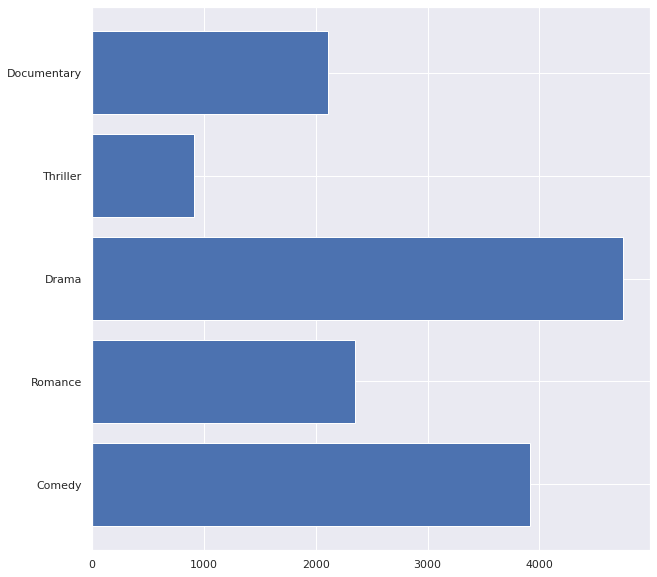

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.barh(list(categories.keys()), list(categories.values()))

# 4. Data Preparation for Genre Prediction Model

4.1 To be able to better predict from the overviews, we had to 'clean' each overview. Our function, clean_text, removes any punctuation marks and converts all text to its lowercase value. 

We also applied word lemmatization, the process of converting a word to its base form. As compared to stemming, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

To compare our results, We create a new column in our dataframe, clean_overview.

In [70]:
# download nltk library first
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [71]:
wordnet_lemmatizer = WordNetLemmatizer()

# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # convert text to lowercase
    text = text.lower() 
    x = text.split()

    # apply lemmattization to words in overview
    for i, j in enumerate(x):
      x[i] = wordnet_lemmatizer.lemmatize(j,pos="v")

    # remove whitespaces 
    text = ' '.join(x) 
    
    return text

df['clean_overview'] = df['overviews'].apply(lambda x: clean_text(x))
df

,titles,overviews,genres,clean_overview
0,Bad Trip,Two pals embark on a road trip full of funny p...,[Comedy],two pal embark on a road trip full of funny pr...
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"[Comedy, Romance]",incurable romantic lotte find her life upend w...
2,After We Collided,Tessa finds herself struggling with her compli...,"[Romance, Drama]",tessa find herself struggle with her complicat...
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,[Comedy],prince akeem joffer be set to become king of z...
4,彼女,Rei helps the woman she's been in love with fo...,"[Drama, Romance, Thriller]",rei help the woman shes be in love with for ye...
...,...,...,...,...
9995,おくりびと,"Daigo, a cellist, is laid off from his orchest...",[Drama],daigo a cellist be lay off from his orchestra ...
9996,The Science of Interstellar,Matthew McConaughey narrates a fascinating loo...,[Documentary],matthew mcconaughey narrate a fascinate look a...
9997,The Gospel According to Philip K. Dick,"Writers, publishers, fans, and friends share t...",[Documentary],writers publishers fan and friends share their...
9998,Alcatraz: Search for the Truth,More than 50 years after three men broke out o...,[Documentary],more than years after three men break out of t...


4.2.1 Generally, we can roughly tell what a movie is about and what genre it is likely under based on certain words. Hence, we would expect some of these words to be used often under a certain genre. 

Our function, freq_words, helps us identify those words. And based on the bar plot that was printed out, we can see the 20 most frequently used words.

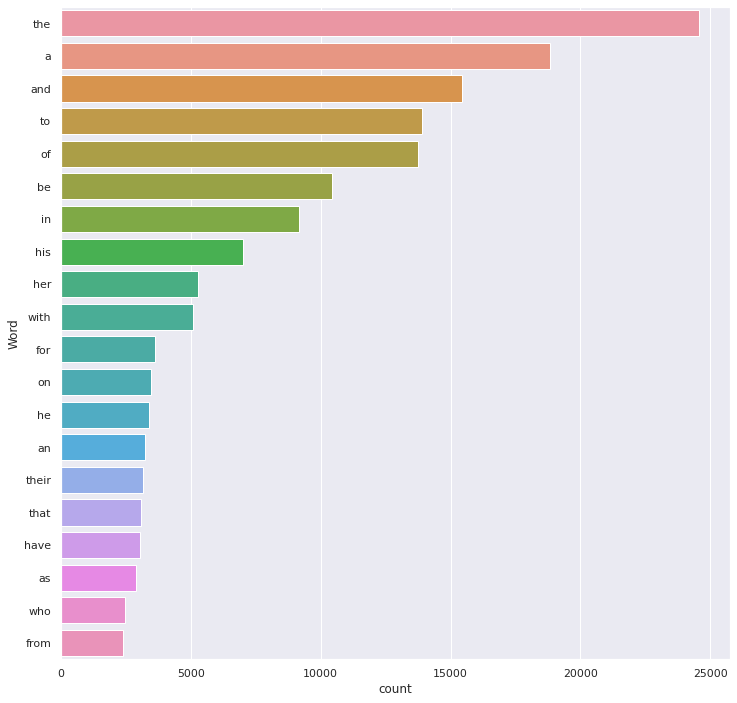

In [72]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,12)) 
  ax = sb.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(df['clean_overview'], 20)

4.3.1 As you may have noticed, the top most words that frequently appear are words that are universally used in overview writing. These are called stopwords. These stopwords carry far less meaning than other keywords in the text (they just add noise to the data). 

We are going to go ahead and remove them from the plots’ text. We obtained the list of stopwords from the nltk library:

In [73]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_overview'] = df['clean_overview'].apply(lambda x: remove_stopwords(x))

4.3.2 Now that we have removed the stopwords from our dataframe, the words shown on the new bar plot shows more distinct words that cater to our chosen genres.

For example, the 6th most frequently used word is 'love', which is word we tend to associate with Romance movies.

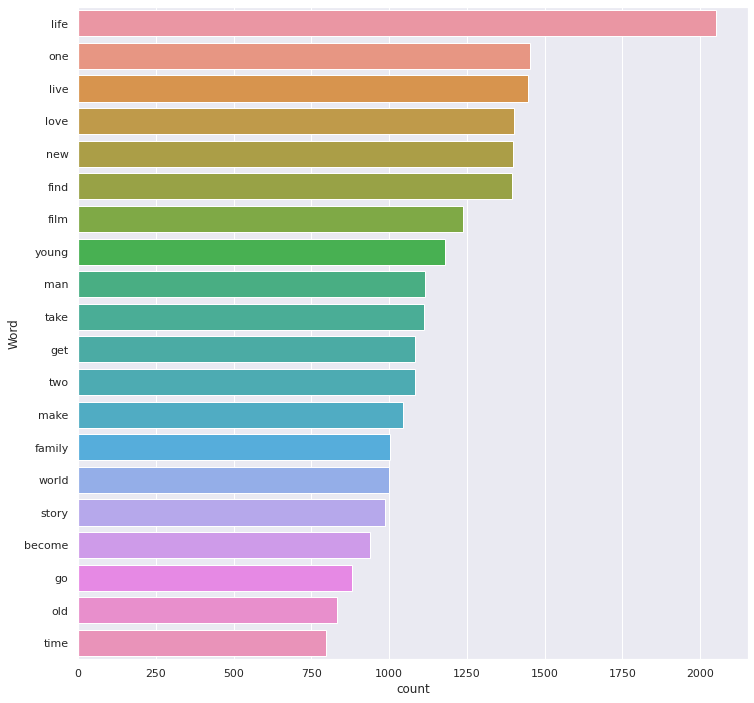

In [75]:
freq_words(df['clean_overview'], 20)

# 5. Converting Text to Features
5.1 Now, we will one hot encode the target variable, i.e., genres by using sklearn’s MultiLabelBinarizer( ).

> The classes generated are our chosen genres

In [76]:
from sklearn.preprocessing import MultiLabelBinarizer

df['genres'] = df['genres'].apply(lambda x: ','.join(map(str, x)))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'].dropna().str.split(','))

print(mlb.classes_)

['Comedy' 'Documentary' 'Drama' 'Romance' 'Thriller']


5.2 To extract features from the cleaned version of the movie overviews data, we used TF-IDF.

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert a collection of raw documents to a matrix of TF-IDF features 
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

5.3 But first, we split our data into train and test sets. We decided on 80% of the data samples to go into the train set and remaining 20% in the test set

In [78]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df['clean_overview'], y, test_size=0.2, random_state=9)

print("Number transactions xtrain dataset: ", xtrain.shape)
print("Number transactions ytrain dataset: ", ytrain.shape)
print("Number transactions xtest dataset: ", xtest.shape)
print("Number transactions ytest dataset: ", ytest.shape)

Number transactions xtrain dataset:  (7598,)
Number transactions ytrain dataset:  (7598, 5)
Number transactions xtest dataset:  (1900,)
Number transactions ytest dataset:  (1900, 5)


5.4 Finally, we created features for the train and the test set by fitting and transforming xtrain and xtest

In [79]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

# 6. Creation of Genre Prediction Model

6.1 As seen above, our dataset is pretty big, and we would expect it to take a considerable amount of time on a modest system to train.

> Therefore, we built a `Logistic Regression` model to quickly train on limited computational power

In [80]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

6.2 We also made use of sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem

In [81]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

6.3 Fitted the model on the train set

In [82]:
#fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

6.4 Predicted movie genres on the test set

In [83]:
y_pred = clf.predict(xtest_tfidf)

> y_pred will output a binary one-dimensional array aka the one-hot encoded form of the unique genre tags. To convert to the actual name of genres:


```
multilabel_binarizer.inverse_transform(y_pred)[3]
```



6.5 to predict probabilities

In [84]:
y_pred_prob = clf.predict_proba(xtest_tfidf)

6.6 We explored different threshold values

> Threshold is 0.5 by default. Meaning if output probability is >0.5 than it is classified as 1 else 0.

> We checked for multiple thresholds and pick one which will gave the highest micro f1 measure. The values obtained are shown in the table below:

| **Threshold Value** | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Accuracy Score (to 4dp)** | 0.0526 | 0.1563 | 0.2805 | **0.3816** | 0.3679 | 0.3037 | 0.1863 | 0.08842 | 0.02684 | 0.0 |
| **F1 Score (to 4dp)** | 0.5764 | 0.6633 | 0.6952 | **0.7014** | 0.6506 | 0.5533 | 0.3871 | 0.1967 | 0.0464 | 0.0 |

> Based on the results, a threshold value of **0.4** gave the best accuracy and F1 score. Hence, we will be using it as our chosen threshold value for our y_pred_new.

In [85]:
t = 0.4 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

6.7 Final Results

> Though the accuracy isn't that high, it has a great F1 score, which is more important in our case as the number of actual correct predictors is what will help us achieve our goal.


In [86]:
print("Accuracy Score: ", accuracy_score(ytest, y_pred_new))
print("F1 Score: ", f1_score(ytest, y_pred_new, average="micro"))

Accuracy Score:  0.3778947368421053
F1 Score:  0.7001215488800139


> It is time to test our model. Here we have a function to do the neccesary cleaning and output the predicted genre.

In [87]:
def PredictedGenres(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    predicted_genres = mlb.inverse_transform(q_pred)
    return predicted_genres

In [98]:
print("Possible genre predictions:", list(categories.keys()))
print()
for i in range(5): 
  k = xtest.sample(1).index[0] 
  print("Movie: ", df['titles'][k], "\nPredicted genre: ", PredictedGenres(xtest[k])), print("Actual genre: ",df['genres'][k], "\n")

Possible genre predictions: ['Comedy', 'Romance', 'Drama', 'Thriller', 'Documentary']

Movie:  Demetri Martin: Standup Comedian 
Predicted genre:  [('Comedy',)]
Actual genre:  Comedy 

Movie:  Siempre, Luis 
Predicted genre:  [('Documentary',)]
Actual genre:  Documentary 

Movie:  In Vogue: The Editor's Eye 
Predicted genre:  [('Documentary',)]
Actual genre:  Documentary 

Movie:  Batalla en el cielo 
Predicted genre:  [('Drama', 'Thriller')]
Actual genre:  Drama 

Movie:  Enough Said 
Predicted genre:  [('Comedy', 'Drama', 'Romance')]
Actual genre:  Comedy,Drama,Romance 



**We have completed our first model!**

> It is a good and serviceable model, but we have yet to achieve our goal. We willing be testing on more models to see how NLP - MLC compares to them.